In [1]:
from fastai.vision.all import *

import PIL
import random

In [2]:
base_path = Path('src')

img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

In [3]:
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

Substitute image name for image path

In [4]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

## create smaller dataset

In [5]:
x = df_train['label_group'].unique()
y = np.random.choice(x, size = int(len(x)*0.1), replace = False)
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [6]:
#files = L([x for x in files if x in df_train.image.tolist()])
files = L(df_train['image'].tolist())

In [7]:
img = PIL.Image.open(files[0])

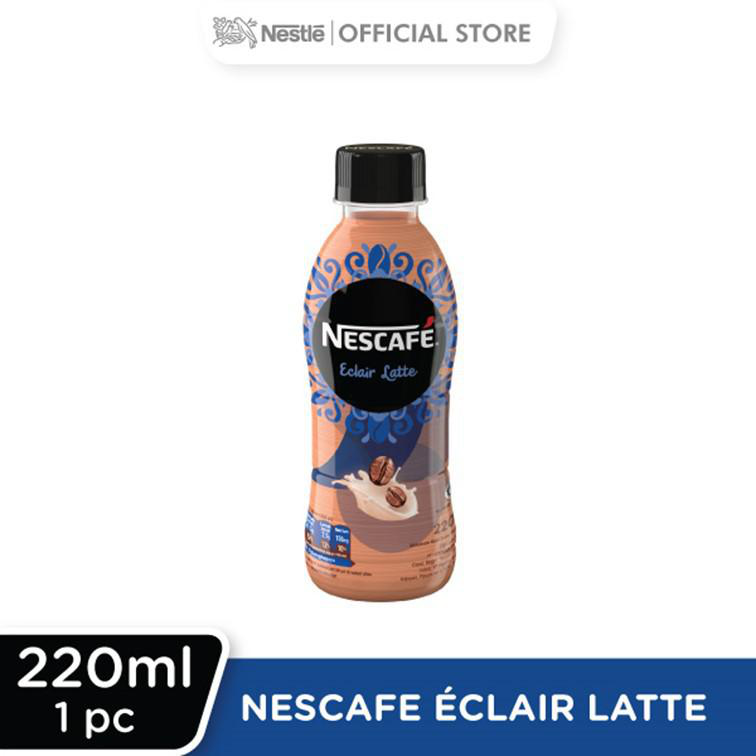

In [8]:
img

In [9]:
def open_image(fname, size = 224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    
    return t.permute(2,0,1).float()/255.

In [10]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [11]:
def label_func(fname):
    return df_train[df_train['image'] == fname]['label_group'].values[0]

In [12]:
label_func(files[0])

3648931069

In [13]:
labels = L(df_train.label_group.unique().tolist())
lbl2files = {label: [name for name in df_train[df_train['label_group'] == label]['image'].to_list()] for label in labels}

## Remove f from random.choice(lbl2files[cls]) in _draw?

In [14]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid = False):
        self.files, self.is_valid = files, is_valid
        if is_valid: 
            self.files2 = [self._draw(f) for f in files]
            
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2, same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1, img2 = open_image(file1), open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5 #indicator if draw has the same label as f
        cls = label_func(f) # label of f
        if not same: 
            cls = random.choice([l for l in labels if l != cls]) # choose a class that is different than cls
        return random.choice(lbl2files[cls]), same

In [15]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [16]:
train_files[0]

Path('src/train_images/2add653ac9297132b476055e1b3dbc5f.jpg')

In [17]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid = True)

In [18]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [19]:
b = dls.one_batch()

In [20]:
dls = dls.cuda()

--------

In [21]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [22]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [23]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [24]:
class SiameseImage(fastuple):
    def show(self, ctx = None, **kwarks):
        if len(self) > 2:
            img1, img2, similarity = self
        else:
            img1, img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size:
                img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
        else:
            t1, t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim = 2), title = similarity, ctx = ctx, **kwarks)

<AxesSubplot:title={'center':'False'}>

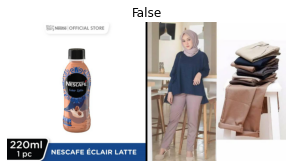

In [25]:
img1 = PILImage.create(files[0])
img2 = PILImage.create(files[1])
s = SiameseImage(img1, img2, False)
s.show()

<AxesSubplot:title={'center':'False'}>

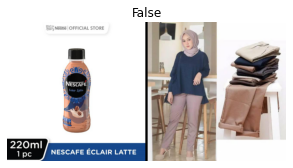

In [26]:
tst = Resize(600)(s)
tst = ToTensor()(tst)
tst.show()

splits = train_idx, valid_idx

In [27]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in split_labels[split] if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [28]:
def split_by_label(files, valid_pct = 0.2):
    df = df_train.copy()
    ## permutated indices of labels list
    label_idx = torch.randperm(len(labels))
    cut = int(valid_pct * len(labels))

    val_labels = labels[label_idx[:cut]]
    train_labels = labels[label_idx[cut:]]

    val_idx = df_train[df_train['label_group'].isin(val_labels)].index.tolist()
    train_idx = df_train[~df_train['label_group'].isin(val_labels)].index.tolist()
    
    return train_idx, val_idx, train_labels, val_labels

In [29]:
files = L(df_train['image'].tolist())

train_idx, val_idx, train_labels, val_labels = split_by_label(files)
splits = (train_idx, val_idx)
split_labels = (train_labels, val_labels)

valid_mask = df_train['label_group'].isin(val_labels)
df_train['is_valid'] = valid_mask

In [30]:
X = set(list(files[splits[0]]))
Y = set(df_train[df_train['is_valid'] == 0].image.tolist())

print(len(X), len(Y))
X == Y

2637 2637


True

Sanity check:

In [31]:
r = df_train.loc[splits[0]].label_group.unique()
s = df_train.loc[splits[1]].label_group.unique()
print('labels that are in train AND validation set: {}'.format(set(r).intersection(set(s))))
print('Sum of training labels and validation labels:', len(r) + len(s))

labels that are in train AND validation set: set()
Sum of training labels and validation labels: 1101


In [32]:
tfm = SiameseTransform(files, splits)

-------------

In [33]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [34]:
tls = TfmdLists(files, tfm, splits=splits)

In [35]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [36]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

In [37]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [38]:
b = dls.one_batch()

In [39]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

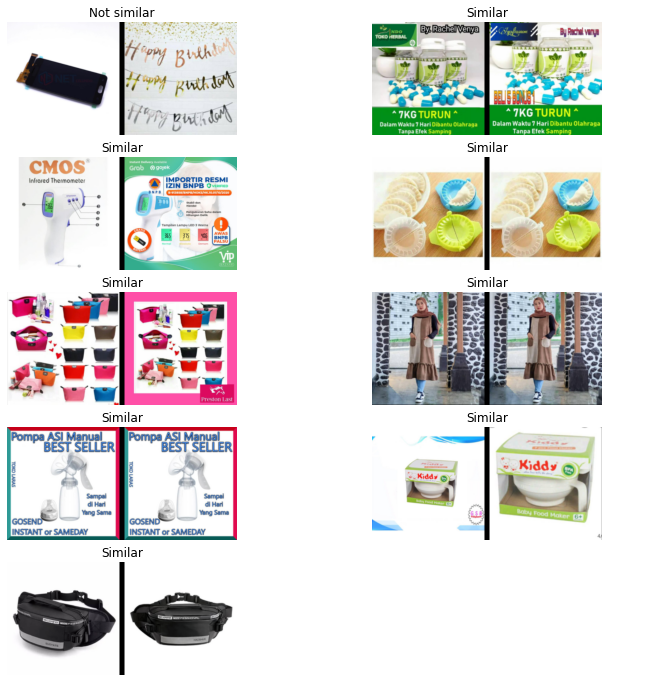

In [40]:
dls.show_batch()

-------------
not needed?
-----------------

In [42]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [43]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

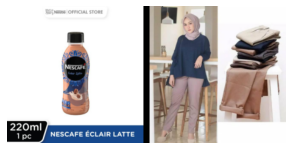

In [44]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [45]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [46]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [47]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [50]:
splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]

In [51]:
def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)

In [52]:
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same

In [53]:
def get_tuples(files): return [[f, *draw_other(f)] for f in files]

In [54]:
def get_x(t): return t[:2]
def get_y(t): return t[2]

In [55]:
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

In [56]:
dls = siamese.dataloaders(files)

KeyError: 3959117902

--------------------

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [ ]:
encoder = create_body(resnet34, cut=-2)

In [ ]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                     bs = 8)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, splitter=siamese_splitter, metrics=accuracy)

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(2)

In [57]:
splbl2files

[{258047: [Path('src/train_images/1d7aadc7503b2b4539cc9a5fe41979dd.jpg'),
   Path('src/train_images/3301b8aaccea93d1098995ffbc537335.jpg'),
   Path('src/train_images/eec692257e74fcbc6cb63cb76d0f20e7.jpg')],
  7657592: [Path('src/train_images/7d2243a70ed80e4d44ff51da09fc860c.jpg'),
   Path('src/train_images/daf4cb87c13d25becfee9f2fbd46bbaa.jpg')],
  9784494: [Path('src/train_images/2f37841ca2b1151d0abe825a8a21c18b.jpg'),
   Path('src/train_images/3068ad579da9a2bca37b404028a03c36.jpg')],
  11893592: [Path('src/train_images/20da4838a048f2d23b34a6894e9ebecc.jpg'),
   Path('src/train_images/fe78729e6d14b8cb407f2135befb9466.jpg')],
  16448490: [Path('src/train_images/0fcec586b71191b2e3ea0ef0f0c09cb2.jpg'),
   Path('src/train_images/2d9ef119466eef73a45e4f38ed8f12a1.jpg'),
   Path('src/train_images/36503f3fb2cd398bf23bcbf9c59dc8db.jpg'),
   Path('src/train_images/36503f3fb2cd398bf23bcbf9c59dc8db.jpg'),
   Path('src/train_images/50ccc176b88009612bc944a3dee97620.jpg'),
   Path('src/train_images/